# Praca domowa 5
#### Ilona Bednarz

## Odtworzenie modelu z PD1

### Zmienna objaśniana:
S1 - Are you married?

### Wybrane zmienne objaśniające:

#### numeryczne:

* Q16: How many of your relatives do you see in person at least once a month?  - numeryczna

* pphhsize: Household Size

#### binarne:

* hcm2017q24_church: met in or through church or religious organization

* w6_otherdate_all: In past yr have you met anyone for dating romance or sex (not incl current partner)

### Zbudowany model:
RandomForest

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import waterfall_chart

from IPython.display import display
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

df = pd.read_stata('dane/HCMST_2017.dta')

# wybor zmiennych
X = df[['Q16', 'pphhsize', 'hcm2017q24_church', 'w6_otherdate_all']].copy()
y = df['S1'].copy()

# przygotowanie danych
X['w6_otherdate_all'] = X['w6_otherdate_all'].replace('Refused', np.nan)
y = y[np.sum(X.isna(), axis=1) == 0]
X = X.dropna(axis=0).reset_index(drop=True)
bin_columns = ["hcm2017q24_church", "w6_otherdate_all"]
dummies = pd.get_dummies(X[bin_columns]).iloc[:, [1, 4]]
dummies.columns = bin_columns
X[bin_columns] = dummies
y = pd.get_dummies(y).iloc[:, 0].reset_index(drop=True) # 1 == married

# dopasowanie modelu
rf = RandomForestClassifier(n_jobs=-1, n_estimators=600, random_state=123, max_depth=4)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

#### Utworzenie drugiego modelu o innej strukturze - model SVM

In [3]:
svm_mod = svm.SVC(kernel='rbf', gamma=0.001, C=2000, probability = True)
svm_mod.fit(X, y)

SVC(C=2000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Porównanie jakości predykcji obu modeli

In [4]:
print('Random forest score AUC: ', np.mean(cross_val_score(rf, X, y, cv=10, scoring='roc_auc', n_jobs=-1)))
print('SVM score AUC: ', np.mean(cross_val_score(svm_mod, X, y, cv=10, scoring='roc_auc', n_jobs=-1)))

Random forest score AUC:  0.7002180146564475
SVM score AUC:  0.6808955055802071


Modele mają zbliżone AUC pomimo różnej struktury.

#### Istotność zmiennych w modelach

In [6]:
def calc_auc(model, X, y):
    preds = model.predict_proba(X)[:,1]
    fpr, tpr, threshold = roc_curve(y, preds)
    return auc(fpr, tpr)

def feature_importances(model, X, y):
    features = X.columns.tolist()
    importances = dict.fromkeys(features)
    L = calc_auc(model, X, y)
    for feature in features:
        X_perm = X.copy()
        X_perm[feature] = np.random.permutation(X[feature].values)
        L_perm = calc_auc(model, X_perm, y)
        importances[feature] = (L-L_perm)/L
    return importances

Wartość oznaczająca istotność zmiennej została obliczona wg wzoru: (L-L_perm)/L, gdzie L oznacza AUC modelu na danych treningowych, natomiast L_perm oznacza AUC modelu po przepermutowaniu wybraej zmiennej.

In [9]:
imp_rf = feature_importances(rf, X, y)
imp_svm = feature_importances(svm_mod, X, y)
print('Istotność zmiennych Random Forest: ', imp_rf)
print('Istotność zmiennych SVM: ', imp_svm)

Istotność zmiennych Random Forest:  {'hcm2017q24_church': 0.02153166823011468, 'pphhsize': 0.1450115109634452, 'Q16': 0.05850830246925134, 'w6_otherdate_all': 0.06592689417014565}
Istotność zmiennych SVM:  {'hcm2017q24_church': 0.015717785966469073, 'pphhsize': 0.10447687766480805, 'Q16': 0.034866301391005765, 'w6_otherdate_all': 0.08353799702891986}


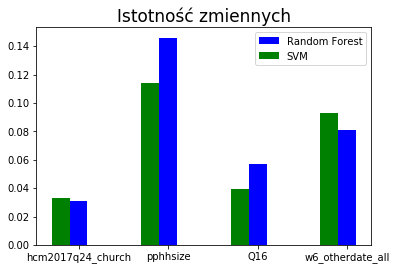

In [13]:
# ilustracja wyników
x = np.arange(len(imp_rf))
ax = plt.subplot(111)
ax.bar(x, imp_rf.values(), width=0.2, color='b', align='center')
ax.bar(x-0.2, imp_svm.values(), width=0.2, color='g', align='center')
ax.legend(('Random Forest','SVM'))
plt.xticks(x, imp_rf.keys())
plt.title("Istotność zmiennych", fontsize=17)
plt.show()

### Interpretacja wykresu
Kolejność zmiennych pod względem istotności jest taka sama w obydwu modelach. Różnią się jednak wartości tej istotności. W obu modelach największy wpływ na bycie w związku małżeńskim ma zmienna pphhsize oznaczająca wielkość gospodarstwa domowego, lecz wartość wskaźnika istotności jest znacznie wyższa dla modelu Random Forest.

Nie dziwi nas istotność tej zmiennej, gdyż wiemy, że osoby żyjące w małżeństwie prawie zawsze mieszkają razem, natomiast osoby samotne często mieszkają same.

### Wykresy PDP

In [32]:
def pdp_plot_data(var, X, mod):
    values = np.arange(min(X[var]),max(X[var])+1)
    cps = []
    for obs in range(X.shape[0]):
        print(obs, '/', X.shape[0])
        row = X.iloc[obs,:].copy()
        cp = []
        for z in values:
            row[var] = z
            cp.append(mod.predict_proba([row])[0][1])
        cps.append(cp)
    cps_mean = np.mean(cps, axis=0)
    return values, cps_mean

def pdp_plot(values, cps_mean, var, mod_name):
    sns.lineplot(x=values, y=cps_mean)
    plt.xlabel(var)
    plt.ylabel('Predicted probability')
    plt.title('Partial Dependence Plot for ' + mod_name)
    plt.show()

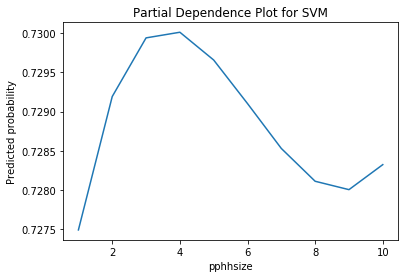

In [39]:
values, cps_mean = pdp_plot_data('pphhsize', X, svm_mod)
pdp_plot(values, cps_mean, 'pphhsize', 'SVM')

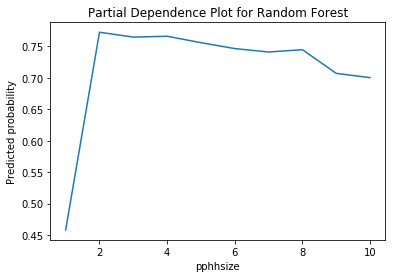

In [43]:
values, cps_mean = pdp_plot_data('pphhsize', X, rf)
pdp_plot(values, cps_mean, 'pphhsize', 'Random Forest')

### Wnioski

Zmienna wybrana do narysowania profili: pphhsize.

Widzimy, że dla wartości pphhsize=1, która oznacza, że osoba mieszka sama, na wykresie PDP prawdopodobieństwo posiadania małżonka jest znacznie niższe niż dla pozostałych wartości. Taka sytuacja ma miejsce zarówno w modelu SVM jak i Random Forest. Różnica jednak polega na tym, że dla modelu Random Forest obserwujemy gwałtowny skok pomiędzy 1 i 2, natomiast dla SVM przejście jest płynne. Wynika to oczywiście ze specyfiki modelu - SVM z jądrem radialnym (które zostało tu użyte) znajduje gładką powierzchnię rozdzielającą kategorie, zatem nie może nastąpić gwałtowny skok pomiędzy wartościami zmiennej ciągłej. Natomiast dla modeli opartych na drzewach typowe są zależości schodkowe.

Można zauważyć też, że w przypadku SVM prawdopodobieństwo bycia w małżeństwie znacznie spada w okolicach wartości 8, co nie ma miejsca dla lasu losowego. Prawdopodobnie jest to efekt uboczny użycia w SVM jądra radialnego.